<a href="https://www.kaggle.com/code/mrohinigowda/eye-eye?scriptVersionId=244268108" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eye-diseases-classification


In [41]:
import os

dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

print("Classes found inside 'dataset' folder:")
for item in os.listdir(dataset_path):
    path = os.path.join(dataset_path, item)
    if os.path.isdir(path):
        print(item)


Classes found inside 'dataset' folder:
glaucoma
normal
diabetic_retinopathy
cataract


In [60]:
NUMBER_OF_CLASSES = len(dataset.classes)


In [42]:
from torchvision import datasets, transforms

# Define transforms (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataset path
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Check number of classes and class to index mapping
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)

# Check sample data
print("Number of images:", len(dataset))
print("Sample image tensor shape:", dataset[0][0].shape)  # tensor shape of first image
print("Sample label:", dataset[0][1])


Number of classes: 4
Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of images: 4217
Sample image tensor shape: torch.Size([3, 256, 256])
Sample label: 0


Label : cataract


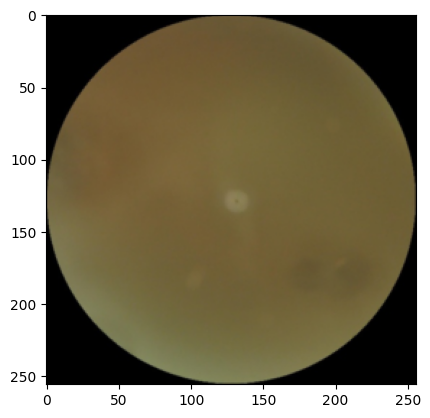

In [47]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[0])

In [49]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset



In [50]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)

In [51]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

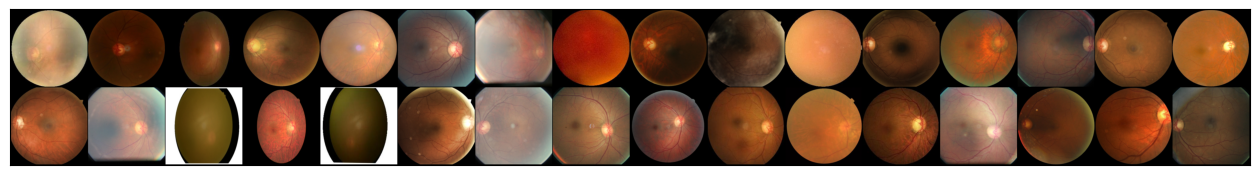

In [52]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)

In [54]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [61]:
model = CNN(NUMBER_OF_CLASSES)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [63]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

In [64]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses

In [65]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)

Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:07<00:00,  3.81it/s]


Epoch 1/10:
Train Loss: 0.86, Train Accuracy: 0.92
Test Loss: 0.69, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:07<00:00,  3.82it/s]


Epoch 2/10:
Train Loss: 0.62, Train Accuracy: 0.62
Test Loss: 0.62, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:06<00:00,  4.17it/s]


Epoch 3/10:
Train Loss: 0.51, Train Accuracy: 0.92
Test Loss: 0.44, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 27/27 [00:06<00:00,  4.13it/s]


Epoch 4/10:
Train Loss: 0.47, Train Accuracy: 0.62
Test Loss: 0.42, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 27/27 [00:06<00:00,  4.11it/s]


Epoch 5/10:
Train Loss: 0.44, Train Accuracy: 0.85
Test Loss: 0.48, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s]


Epoch 6/10:
Train Loss: 0.41, Train Accuracy: 0.62
Test Loss: 0.40, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 27/27 [00:06<00:00,  4.05it/s]


Epoch 7/10:
Train Loss: 0.37, Train Accuracy: 0.85
Test Loss: 0.42, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 27/27 [00:06<00:00,  3.97it/s]


Epoch 8/10:
Train Loss: 0.36, Train Accuracy: 0.85
Test Loss: 0.36, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 27/27 [00:06<00:00,  4.12it/s]


Epoch 9/10:
Train Loss: 0.33, Train Accuracy: 0.92
Test Loss: 0.36, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 27/27 [00:06<00:00,  4.08it/s]

Epoch 10/10:
Train Loss: 0.31, Train Accuracy: 0.85
Test Loss: 0.37, Test Accuracy: 0.92
------------------------------


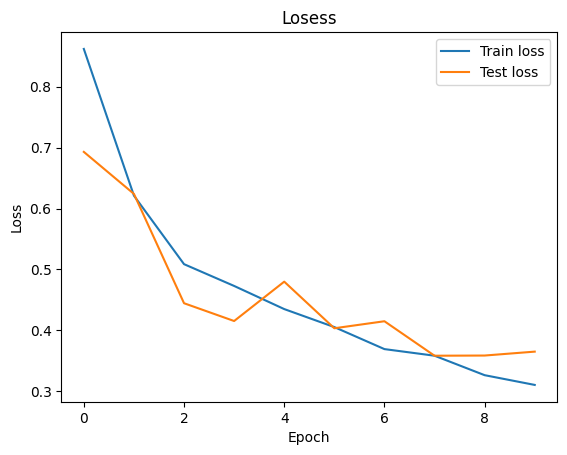

In [66]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [67]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

In [68]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)

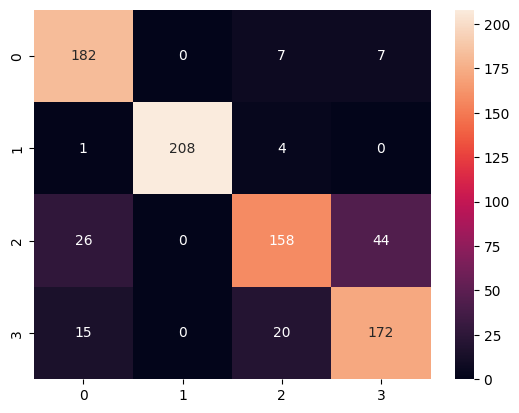

In [69]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [70]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 85.31%


In [71]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 85.31%


In [72]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 85.31%


In [73]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 85.31%


In [74]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO


In [75]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # same size as training
    transforms.ToTensor(),
    # If you used normalization during training, add here:
    # transforms.Normalize(mean=[...], std=[...])
])


In [76]:
def predict_image(image_path_or_url):
    # Load image from URL or local path
    if image_path_or_url.startswith('http'):
        response = requests.get(image_path_or_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path_or_url).convert('RGB')

    # Apply transformations
    input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dim

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_idx = torch.max(output, 1)

    # Get class label
    predicted_class = dataset.classes[predicted_idx.item()]
    return predicted_class


In [85]:
img_path = "/kaggle/input/eye-diseases-classification/dataset/glaucoma/1209_left.jpg"
# OR
#img_url = "https://example.com/sample_eye_image.jpg"

predicted_label = predict_image(img_path)  # or predict_image(img_url)
print(f"Predicted disease: {predicted_label}")


Predicted disease: glaucoma
